## Illustration of $\sigma$-bias

#### Setup

In [3]:
# Install necessary packages in the notebook environment
# !pip install torch numpy dataclasses

In [4]:
import torch

# Define dataset (only produces symmetric samples e.g. [K, K] for any integer K)
class RandomDiagonalDataset(torch.utils.data.Dataset):
    def __init__(self, vocab_size, seq_length, num_samples):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.num_samples = num_samples
        self.samples = torch.randint(low=0, high=self.vocab_size, size=(self.num_samples,))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Each element in the sequence is identical, e.g., [0,0] or [1,1], etc.
        value = self.samples[idx].item()
        input_ids = torch.full((self.seq_length,), fill_value=value, dtype=torch.long)
        target = input_ids.clone()
        return {'input_ids': input_ids, 'labels': target}

In [5]:
# Helpful grid heatmap plotting function

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LogNorm

def plot_heatmap_grid(pys, value='p', col=None, row=None, log=False):
    # --- Convert all heatmaps to a long-form DataFrame ---
    dfs = []
    for entry in pys:
        h, w = entry[value].shape
        yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
        additional_cols = {k: entry[v] for k, v in (('col', col), ('row', row)) if v is not None}
        df = pd.DataFrame({
            "x": xx.ravel(),
            "y": yy.ravel(),
            "value": entry[value].ravel(),
            **additional_cols,
        })
        dfs.append(df)
    df_all = pd.concat(dfs, ignore_index=True)

    # --- Compute global limits for shared color scale ---
    vmin = df_all.loc[df_all["value"] > 0, "value"].min()
    vmax = df_all["value"].max()

    # --- Plot with FacetGrid, make the figure smaller ---
    additional_facet_cols = {k: k for k, v in (('col', col), ('row', row)) if v is not None}
    g = sns.FacetGrid(df_all, height=4, sharex=False, sharey=False, **additional_facet_cols)
    g.map_dataframe(
        lambda data, color=None, **kws: sns.heatmap(
            data.pivot(index="y", columns="x", values="value"),
            cmap="rocket",
            norm=LogNorm(vmin=vmin, vmax=vmax) if log else None,
            cbar=False,
            **kws
        )
    )
    for ax in g.axes.flatten():
        ax.invert_yaxis()  # <-- Simple 1-line change to reverse y so (0,0) is bottom left

    # Shared colorbar on the right
    sm = plt.cm.ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax) if log else None, cmap="rocket")
    sm.set_array([])
    g.fig.colorbar(sm, ax=g.axes, label="Value", location="right")

    g.set_titles(col_template="{col_name}")
    plt.show()

#### Simple Model

In [6]:
import torch
from dataclasses import dataclass
import numpy as np

# Define simple model
@dataclass
class SimpleModelOutput:
    loss: torch.Tensor

class SimpleDensityModel(torch.nn.Module):
    def __init__(self, d_output: int, rank: int, pos_func: str = "abs", mode='factorized', pos_func_mode='factorized'):
        super().__init__()
        self.d_output = d_output
        self.mode = mode
        self.pos_func = pos_func
        self.pos_func_mode = pos_func_mode

        if self.mode == 'factorized':
            # Decompose into two rank-r matrices
            self._p1 = torch.nn.Parameter(torch.randn(d_output, rank))
            self._p2 = torch.nn.Parameter(torch.randn(rank, d_output))
        elif self.mode == 'full':
            # Model full matrix
            self._p_tilde = torch.nn.Parameter(torch.randn(d_output, d_output))
        else:
            raise ValueError(f"Invalid mode: {self.mode}")
        

    @property
    def p_tilde(self): # Materializes unnormalized dist (d_output, d_output)
        pos_func = {
            "abs": torch.abs,
            "exp": torch.exp,
            "sigmoid": torch.sigmoid,
        }[self.pos_func]
        if self.mode == 'factorized':
            if self.pos_func_mode == 'factorized':
                p_tilde = pos_func(self._p1) @ pos_func(self._p2)
            else:
                p_tilde = pos_func(self._p1 @ self._p2)
        elif self.mode == 'full':
            p_tilde = pos_func(self._p_tilde)
        return p_tilde

    # Converts flat indices to multi-index 
    @staticmethod
    def _torch_unravel_index(indices, shape):
        id_tuples = np.unravel_index(indices, shape)
        return torch.stack([torch.tensor(t) for t in id_tuples], dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Shape of x: (B, 2)
        ids = x[:, 0] * self.d_output + x[:, 1]  # (B,)
        p = self.p_tilde
        loss = p.sum().clamp(min=1e-12).log() - p.reshape(-1)[ids].clamp(min=1e-12).log()
        return loss.sum()

    def sample(self, n_samples: int) -> torch.Tensor:
        p_tilde = self.p_tilde
        p = p_tilde.reshape(-1)
        ids = torch.multinomial(p, n_samples, replacement=True)  # (n_samples,)
        return self._torch_unravel_index(ids, (self.d_output, self.d_output))

# Setup
torch.manual_seed(12)
num_samples = 2
batch_size = 128
d_output = 16
dataset = RandomDiagonalDataset(d_output, 2, num_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_simple_model(
    # --- Model configuration ---
    d_output: int = 16,
    rank: int = 16,
    pos_func: str = "sigmoid",
    mode: str = "factorized",
    pos_func_mode: str = "factorized",

    # --- Training configuration ---
    n_epochs: int = 20_000,
    lr: float = 1e-3,
    **kwargs,
):
    model = SimpleDensityModel(d_output=d_output, rank=rank, pos_func=pos_func, mode=mode, pos_func_mode=pos_func_mode)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        train_losses = []
        for i, batch in enumerate(dataloader):
            x = batch['input_ids']
            loss = model(x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        loss_avg = sum(train_losses)/len(train_losses)
        if epoch % 5_000 == 0:
            print(f"[Epoch {epoch}/{n_epochs}] Loss: {loss_avg:.2f}")
    return model

In [24]:
exps = [
    # abs
    {'name': 'Factorized (pre $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'factorized', 'pos_func': 'abs'}, 
    {'name': 'Factorized (post $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'full', 'pos_func': 'abs'},
    {'name': 'Full', 'mode': 'full', 'pos_func_mode': 'full', 'pos_func': 'abs'},
    # # sigmoid
    # {'name': 'Factorized (pre $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'factorized', 'pos_func': 'sigmoid'}, 
    # {'name': 'Factorized (post $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'full', 'pos_func': 'sigmoid'},
    # {'name': 'Full', 'mode': 'full', 'pos_func_mode': 'full', 'pos_func': 'sigmoid'},
    # # exp
    # {'name': 'Factorized (pre $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'factorized', 'pos_func': 'exp'}, 
    # {'name': 'Factorized (post $\\sigma$)', 'mode': 'factorized', 'pos_func_mode': 'full', 'pos_func': 'exp'},
    # {'name': 'Full', 'mode': 'full', 'pos_func_mode': 'full', 'pos_func': 'exp'},
]

pys = []
for exp in exps:
    model = train_simple_model(**exp)
    pys.append({**exp, 'p': model.p_tilde.detach().numpy()})

[Epoch 0/20000] Loss: 11.09
[Epoch 5000/20000] Loss: 0.00
[Epoch 10000/20000] Loss: 0.00
[Epoch 15000/20000] Loss: 0.00
[Epoch 0/20000] Loss: 10.08
[Epoch 5000/20000] Loss: 0.03
[Epoch 10000/20000] Loss: 0.02
[Epoch 15000/20000] Loss: 0.02
[Epoch 0/20000] Loss: 12.51
[Epoch 5000/20000] Loss: 0.03
[Epoch 10000/20000] Loss: 0.02
[Epoch 15000/20000] Loss: 0.01


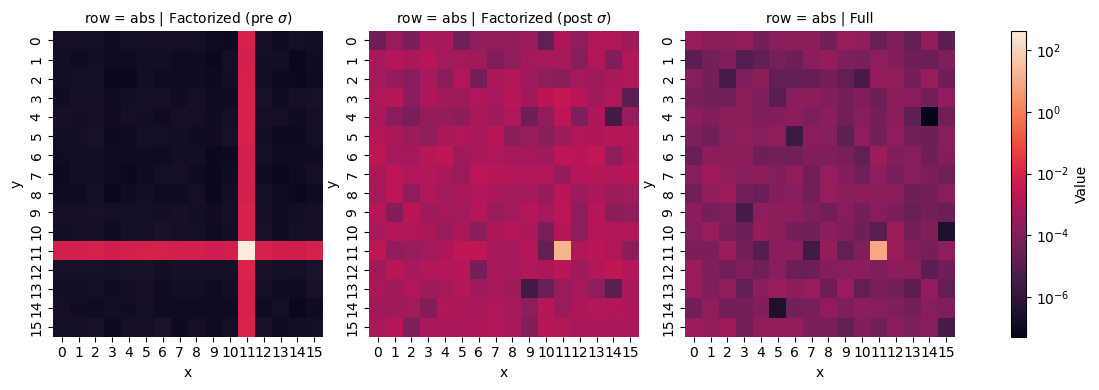

In [ ]:
# filter only include abs
_pys = [p for p in pys if p['pos_func'] == 'abs']
plot_heatmap_grid(_pys, col='name', row='pos_func')


#### MPS

In [35]:
import torch
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig

# Setup
torch.manual_seed(12)
num_samples = 4
batch_size = 128
d_output = 16
dataset = RandomDiagonalDataset(d_output, 2, num_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_mps_model(
    # --- Model configuration ---
    d_output: int = 16,
    rank: int = 4,
    pos_func: str = "abs",
    model_name: str = "mps_sigma_lsf",
    horizon: int = 2,
    init_method: str = "ortho",

    # --- Training configuration ---
    n_epochs: int = 10_000,
    lr: float = 1e-3,
    **kwargs,
):
    model = dists[model_name](
        AbstractDisributionHeadConfig(
            d_model=1,
            d_output=d_output,
            horizon=horizon,
            rank=rank,
            pos_func=pos_func,
            init_method=init_method,
        )
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)

    for epoch in range(n_epochs):
        train_losses = []
        for i, batch in enumerate(dataloader):
            x = batch['input_ids']
            out = model(torch.ones_like(x), x)
            loss = out.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        loss_avg = sum(train_losses)/len(train_losses)
        if epoch % 1_000 == 0:
            print(f"[Epoch {epoch}/{n_epochs}] Loss: {loss_avg:.2f}")
    return model

In [36]:
exps = [
    # abs
    {'name': '$\\mathrm{MPS}_\\sigma$', "model_name": "mps_sigma_lsf"},
    {'name': '$\\mathrm{MPS}_{\\mathrm{BM}}$', "model_name": "mps_bm_lsf"},
]

pys_mps = []
for exp in exps:
    model = train_mps_model(**exp)
    pys_mps.append({**exp, 'p': model.materialize(torch.ones(1, 1)).detach().squeeze(0).numpy()})

[Epoch 0/10000] Loss: 2.96
[Epoch 1000/10000] Loss: 0.74
[Epoch 2000/10000] Loss: 0.52
[Epoch 3000/10000] Loss: 0.52
[Epoch 4000/10000] Loss: 0.52
[Epoch 5000/10000] Loss: 0.52
[Epoch 6000/10000] Loss: 0.52
[Epoch 7000/10000] Loss: 0.52
[Epoch 8000/10000] Loss: 0.52
[Epoch 9000/10000] Loss: 0.52
[Epoch 0/10000] Loss: 2.77
[Epoch 1000/10000] Loss: 1.04
[Epoch 2000/10000] Loss: 1.04
[Epoch 3000/10000] Loss: 1.04
[Epoch 4000/10000] Loss: 1.04
[Epoch 5000/10000] Loss: 1.04
[Epoch 6000/10000] Loss: 1.04
[Epoch 7000/10000] Loss: 1.04
[Epoch 8000/10000] Loss: 1.04
[Epoch 9000/10000] Loss: 1.04


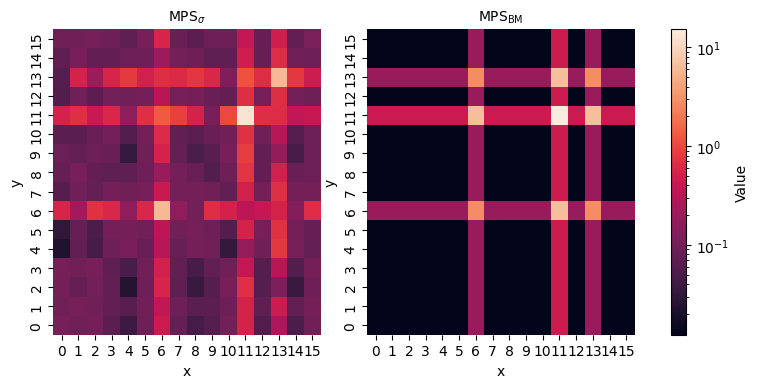

In [37]:
# filter only include abs
plot_heatmap_grid(pys_mps, value='p', col='name', log=True)

                              mean   std
Model                                   
$\mathrm{MPS}_\sigma$         1.27  2.95
$\mathrm{MPS}_{\mathrm{BM}}$  0.92  2.45


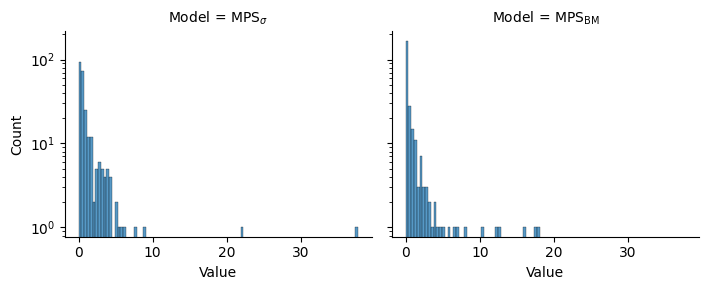

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Build DataFrame and print stats
df = pd.concat([
    pd.DataFrame({'Value': p['p'].flatten(), 'Model': p['name']})
    for p in pys_mps
])
stats = df.groupby('Model')['Value'].agg(['mean', 'std'])
print(stats.round(2))

# Plot with smaller figure size and log y-axis
g = sns.displot(
    data=df, 
    x="Value", 
    col="Model", 
    kind="hist", 
    bins=100, 
    facet_kws={'sharex': True},
    height=3,  # smaller height
    aspect=1.2 # smaller width
)
for ax in g.axes.flat:
    ax.set_yscale('log')
plt.show()
